<img heigth="8" src="https://i.imgur.com/3mimh4M.png" alt="guane">

<h1 align="left">Data Science and Machine Learning</h1>

<p align="left"><i>A Data Project Template for Building Robust, Reproducible and Maintainable Predictive Solutions</i></p>

<p align="left">
  DS&ML Team | <a href="https://guane.com.co/">guane enterprises</a>
  <br>
  <b>Last updated:</b> <i>06/03/2023</i>
  <br><br>
  <a target="_blank">
    <img src="https://github.com/QData/TextAttack/workflows/Github%20PyTest/badge.svg" alt="Testing">
  </a>
  <a href="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000">
    <img src="https://img.shields.io/badge/version-0.1.0-blue.svg?cacheSeconds=2592000" alt="Version" height="18">
  </a>
</p><br>
<p align="left">
  <a href="#introduction">Introduction</a><br>
  <a href="#1-data-adquisition">1. Data Adquisition</a><br>
  <a href="#2-exploratory-data-analysis">2. Exploratory Data Analysis</a><br>
  <a href="#3-training-models">3. Training Models</a><br>
  <br>
</p>

---

With this notebook you can test the template to develop your predictive solution.

In [1]:
import pandas as pd
import seaborn as sns
import pickle

In [2]:
import sys
sys.path.append("..")

import src
from src.utils import set_seed_everything

print(f"[INFO] Package version: {src.__version__}")

[INFO] Package version: v0.1.0


In [3]:
SEED = 20180507
set_seed_everything(SEED)

<a id="3-training-models"></a>
## 3. Training Models

We need to pre-process the data before training models. For that, we'll encode categorical features and scale numerical ones.

In [4]:
data_to_model_with = pd.read_csv("../storage/data/data_with_metadata_to_model_with.csv")

In [5]:
data_to_model_with

,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id,cluster
0,0,11,179.135763,REA,classic,cross_docking,free_shipping,14,MLB,3
1,1,22,135.900000,REA,premium,fulfillment,free_shipping,19,MLB,3
2,2,1,250.304348,MEX,premium,drop_off,paid_shipping,0,MLM,3
3,3,8,399.000000,MEX,premium,fulfillment,free_shipping,14,MLM,3
4,4,39,116.233729,REA,premium,fulfillment,free_shipping,4,MLB,4
...,...,...,...,...,...,...,...,...,...,...
535703,660911,19,12.803898,REA,classic,fulfillment,paid_shipping,7,MLB,2
535704,660912,14,99.000000,MEX,classic,fulfillment,paid_shipping,11,MLM,2
535705,660913,10,141.330847,REA,premium,fulfillment,free_shipping,16,MLB,3
535706,660914,23,57.651017,REA,premium,fulfillment,paid_shipping,4,MLB,3


In [6]:
pd.DataFrame({
    "nan": data_to_model_with.isna().sum(),
    "dtype": data_to_model_with.dtypes,
    "nunique": data_to_model_with.nunique()
})

,nan,dtype,nunique
sku,0,int64,535708
sold_quantity,0,int64,2499
current_price,0,float64,242785
currency,0,object,4
listing_type,0,object,2
shipping_logistic_type,0,object,3
shipping_payment,0,object,2
mean_diff,0,int64,59
site_id,0,object,3
cluster,0,int64,5


In [7]:
mex_skus = data_to_model_with[data_to_model_with["currency"] == "MEX"]
mex_sq_q3 = mex_skus["sold_quantity"].quantile(0.75)
mex_sq_q1 = mex_skus["sold_quantity"].quantile(0.25)
mex_sq_iqr = mex_sq_q3 - mex_sq_q1

mex_cp_q3 = mex_skus["current_price"].quantile(0.75)
mex_cp_q1 = mex_skus["current_price"].quantile(0.25)
mex_cp_iqr = mex_cp_q3 - mex_cp_q1

mex_core_skus = mex_skus[
    (mex_skus["sold_quantity"] < mex_sq_q3 + 1.5 * mex_sq_iqr) &
    (mex_skus["current_price"] < mex_cp_q3 + 1.5 * mex_cp_iqr)
]

mex_core_skus.describe()

,sku,sold_quantity,current_price,mean_diff,cluster
count,170556.000000,170556.000000,170556.000000,170556.000000,170556.000000
mean,330548.741604,24.786123,274.460565,16.651974,2.045111
std,190578.789292,19.438824,209.857029,12.646675,1.336952
min,2.000000,0.000000,2.400000,0.000000,0.000000
25%,165595.750000,11.000000,112.559322,8.000000,1.000000
50%,330659.000000,19.000000,209.779492,13.000000,2.000000
75%,495310.500000,33.000000,385.000000,22.000000,3.000000
max,660915.000000,91.000000,973.907288,58.000000,4.000000


In [8]:
arg_skus = data_to_model_with[data_to_model_with["currency"] == "ARG"]
arg_sq_q3 = arg_skus["sold_quantity"].quantile(0.75)
arg_sq_q1 = arg_skus["sold_quantity"].quantile(0.25)
arg_sq_iqr = arg_sq_q3 - arg_sq_q1

arg_cp_q3 = arg_skus["current_price"].quantile(0.75)
arg_cp_q1 = arg_skus["current_price"].quantile(0.25)
arg_cp_iqr = arg_cp_q3 - arg_cp_q1

arg_core_skus = arg_skus[
    (arg_skus["sold_quantity"] < arg_sq_q3 + 1.5 * arg_sq_iqr) &
    (arg_skus["current_price"] < arg_cp_q3 + 1.5 * arg_cp_iqr)
]

arg_core_skus.describe()

,sku,sold_quantity,current_price,mean_diff,cluster
count,37514.000000,37514.000000,37514.000000,37514.000000,37514.000000
mean,330312.913152,24.490643,2223.549953,15.073119,1.978648
std,190874.717642,20.306930,2017.661241,11.990069,1.406709
min,18.000000,0.000000,8.000000,0.000000,0.000000
25%,165403.500000,11.000000,700.169492,7.000000,0.000000
50%,329307.000000,18.000000,1518.469746,12.000000,2.000000
75%,496683.500000,33.000000,3285.309322,19.000000,3.000000
max,660887.000000,93.000000,8950.000000,58.000000,4.000000


In [9]:
bra_skus = data_to_model_with[data_to_model_with["currency"] == "REA"]
bra_sq_q3 = bra_skus["sold_quantity"].quantile(0.75)
bra_sq_q1 = bra_skus["sold_quantity"].quantile(0.25)
bra_sq_iqr = bra_sq_q3 - bra_sq_q1

bra_cp_q3 = bra_skus["current_price"].quantile(0.75)
bra_cp_q1 = bra_skus["current_price"].quantile(0.25)
bra_cp_iqr = bra_cp_q3 - bra_cp_q1

bra_core_skus = bra_skus[
    (bra_skus["sold_quantity"] < bra_sq_q3 + 1.5 * bra_sq_iqr) &
    (bra_skus["current_price"] < bra_cp_q3 + 1.5 * bra_cp_iqr)
]

bra_core_skus.describe()

,sku,sold_quantity,current_price,mean_diff,cluster
count,225372.000000,225372.000000,225372.000000,225372.000000,225372.000000
mean,330425.735051,23.056959,65.151024,15.686709,2.034774
std,190856.897628,17.280097,46.834503,11.584949,1.372918
min,0.000000,0.000000,0.890000,0.000000,0.000000
25%,165350.000000,11.000000,29.990000,8.000000,1.000000
50%,330462.500000,18.000000,49.747966,13.000000,2.000000
75%,495504.500000,30.000000,85.515085,19.000000,3.000000
max,660914.000000,81.000000,211.413559,58.000000,4.000000


In [10]:
core_skus = pd.concat([mex_core_skus, arg_core_skus, bra_core_skus])

In [11]:
core_skus

,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id,cluster
2,2,1,250.304348,MEX,premium,drop_off,paid_shipping,0,MLM,3
3,3,8,399.000000,MEX,premium,fulfillment,free_shipping,14,MLM,3
5,5,15,571.748814,MEX,premium,fulfillment,free_shipping,25,MLM,2
6,6,29,490.915254,MEX,classic,fulfillment,free_shipping,22,MLM,2
9,9,18,224.423729,MEX,premium,fulfillment,free_shipping,51,MLM,1
...,...,...,...,...,...,...,...,...,...,...
535700,660907,9,25.262881,REA,premium,fulfillment,paid_shipping,13,MLB,4
535701,660908,75,28.276441,REA,premium,fulfillment,paid_shipping,12,MLB,3
535703,660911,19,12.803898,REA,classic,fulfillment,paid_shipping,7,MLB,2
535705,660913,10,141.330847,REA,premium,fulfillment,free_shipping,16,MLB,3


In [12]:
sample = core_skus.sample(50000, random_state=SEED)

In [13]:
sample

,sku,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id,cluster
401767,495685,42,65.115763,REA,premium,fulfillment,paid_shipping,51,MLB,0
189492,233807,27,199.000000,MEX,classic,fulfillment,paid_shipping,16,MLM,2
353646,436370,52,135.973220,MEX,classic,fulfillment,paid_shipping,1,MLM,3
93819,115799,7,78.900000,REA,premium,fulfillment,paid_shipping,9,MLB,3
449627,554874,24,28.515424,REA,classic,fulfillment,paid_shipping,4,MLB,2
...,...,...,...,...,...,...,...,...,...,...
378275,466680,25,36.900000,REA,classic,fulfillment,paid_shipping,13,MLB,4
207357,255858,13,174.696949,REA,classic,fulfillment,free_shipping,21,MLB,3
526071,649056,40,21.271186,REA,premium,fulfillment,paid_shipping,25,MLB,3
295343,364424,24,754.118644,ARG,classic,fulfillment,paid_shipping,8,MLA,0


In [14]:
sample.describe()

,sku,sold_quantity,current_price,mean_diff,cluster
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,330266.296220,23.775620,329.310103,16.056380,2.034280
std,191123.665518,18.304553,829.631775,12.084365,1.361052
min,0.000000,0.000000,1.444068,0.000000,0.000000
25%,163996.250000,11.000000,44.732415,8.000000,1.000000
50%,329744.000000,19.000000,99.000000,13.000000,2.000000
75%,496085.250000,31.000000,246.110339,20.000000,3.000000
max,660908.000000,93.000000,8937.708136,58.000000,4.000000


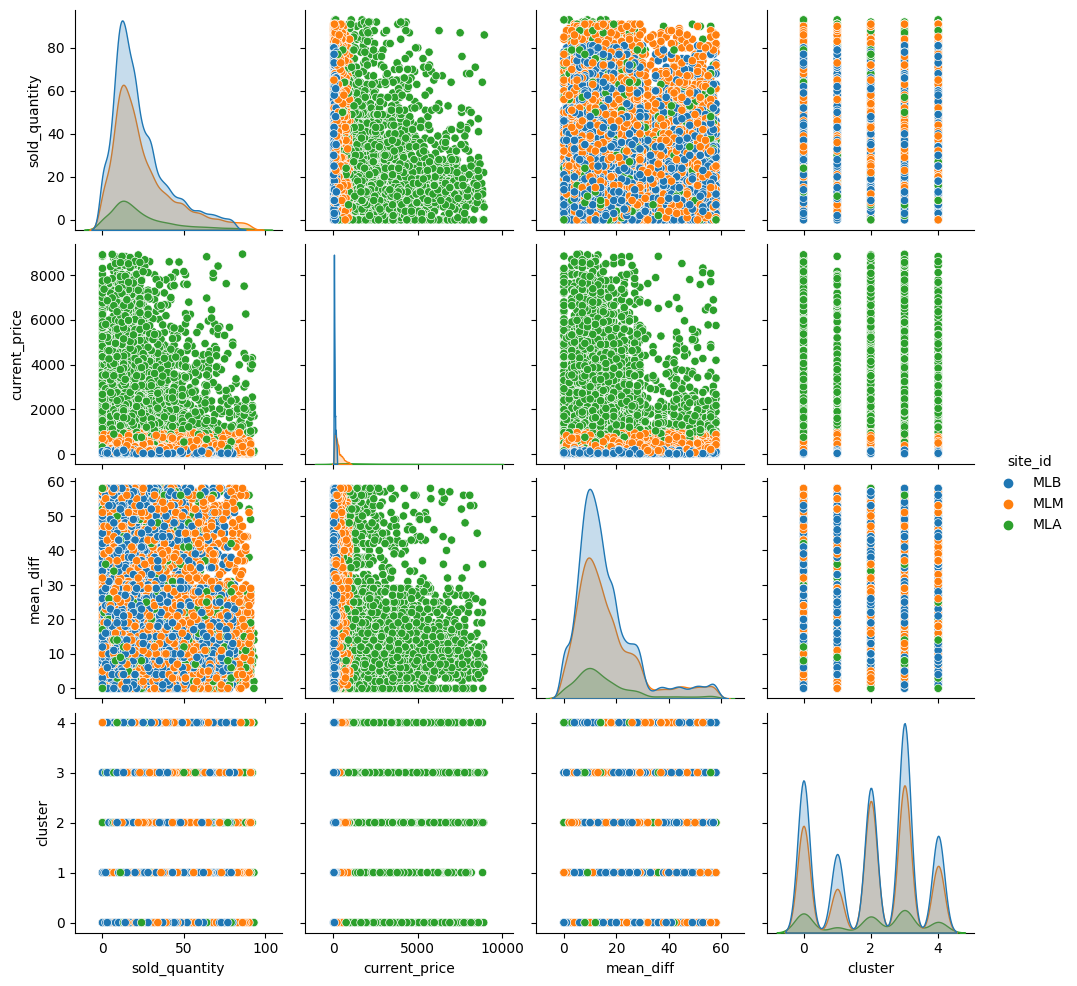

In [15]:
sns.pairplot(sample.drop(columns=["sku"]), hue="site_id")

Although the min and max values of sold quantity are similar for the three markets, the min and max values for current prince are quite different. This leads to scale with different scalers for each country.

### scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler

mex_scaler = MinMaxScaler()
mex_scaled = mex_scaler.fit_transform(mex_core_skus[["sold_quantity", "current_price"]])
mex_core_skus_scaled = mex_core_skus.drop(columns=["sold_quantity", "current_price"])
mex_core_skus_scaled["sold_quantity"] = mex_scaled[:, 0]
mex_core_skus_scaled["current_price"] = mex_scaled[:, 1]

arg_scaler = MinMaxScaler()
arg_scaled = arg_scaler.fit_transform(arg_core_skus[["sold_quantity", "current_price"]])
arg_core_skus_scaled = arg_core_skus.drop(columns=["sold_quantity", "current_price"])
arg_core_skus_scaled["sold_quantity"] = arg_scaled[:, 0]
arg_core_skus_scaled["current_price"] = arg_scaled[:, 1]

bra_scaler = MinMaxScaler()
bra_scaled = bra_scaler.fit_transform(bra_core_skus[["sold_quantity", "current_price"]])
bra_core_skus_scaled = bra_core_skus.drop(columns=["sold_quantity", "current_price"])
bra_core_skus_scaled["sold_quantity"] = bra_scaled[:, 0]
bra_core_skus_scaled["current_price"] = bra_scaled[:, 1]

In [19]:
# with open("../storage/models/MEX_scaler.pkl", "wb") as f:
#     pickle.dump(mex_scaler, f)

# with open("../storage/models/ARG_scaler.pkl", "wb") as f:
#     pickle.dump(arg_scaler, f)

# with open("../storage/models/REA_scaler.pkl", "wb") as f:
#     pickle.dump(bra_scaler, f)

In [28]:
core_skus_scaled = pd.concat([mex_core_skus_scaled, arg_core_skus_scaled, bra_core_skus_scaled])

In [29]:
core_skus_scaled

,sku,currency,listing_type,shipping_logistic_type,shipping_payment,mean_diff,site_id,cluster,sold_quantity,current_price
2,2,MEX,premium,drop_off,paid_shipping,0,MLM,3,0.010989,0.255175
3,3,MEX,premium,fulfillment,free_shipping,14,MLM,3,0.087912,0.408232
5,5,MEX,premium,fulfillment,free_shipping,25,MLM,2,0.164835,0.586047
6,6,MEX,classic,fulfillment,free_shipping,22,MLM,2,0.318681,0.502843
9,9,MEX,premium,fulfillment,free_shipping,51,MLM,1,0.197802,0.228535
...,...,...,...,...,...,...,...,...,...,...
535700,660907,REA,premium,fulfillment,paid_shipping,13,MLB,4,0.111111,0.115773
535701,660908,REA,premium,fulfillment,paid_shipping,12,MLB,3,0.925926,0.130087
535703,660911,REA,classic,fulfillment,paid_shipping,7,MLB,2,0.234568,0.056592
535705,660913,REA,premium,fulfillment,free_shipping,16,MLB,3,0.123457,0.667103


In [30]:
enconded_core_skus = pd.get_dummies(
    core_skus_scaled,
    columns=["currency", "listing_type", "shipping_logistic_type", "shipping_payment", "site_id", "cluster"]
).drop(columns=["listing_type_classic", "shipping_payment_free_shipping"]) #We drop this columns cause their information is redundant since they're binay categories.

In [34]:
enconded_core_skus

,sku,mean_diff,sold_quantity,current_price,currency_ARG,currency_MEX,currency_REA,listing_type_premium,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,shipping_payment_paid_shipping,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
2,2,0,0.010989,0.255175,0,1,0,1,0,1,0,1,0,0,0,1,0
3,3,14,0.087912,0.408232,0,1,0,1,0,0,1,0,0,0,0,1,0
5,5,25,0.164835,0.586047,0,1,0,1,0,0,1,0,0,0,1,0,0
6,6,22,0.318681,0.502843,0,1,0,0,0,0,1,0,0,0,1,0,0
9,9,51,0.197802,0.228535,0,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535700,660907,13,0.111111,0.115773,0,0,1,1,0,0,1,1,0,0,0,0,1
535701,660908,12,0.925926,0.130087,0,0,1,1,0,0,1,1,0,0,0,1,0
535703,660911,7,0.234568,0.056592,0,0,1,0,0,0,1,1,0,0,1,0,0
535705,660913,16,0.123457,0.667103,0,0,1,1,0,0,1,0,0,0,0,1,0


<Axes: >

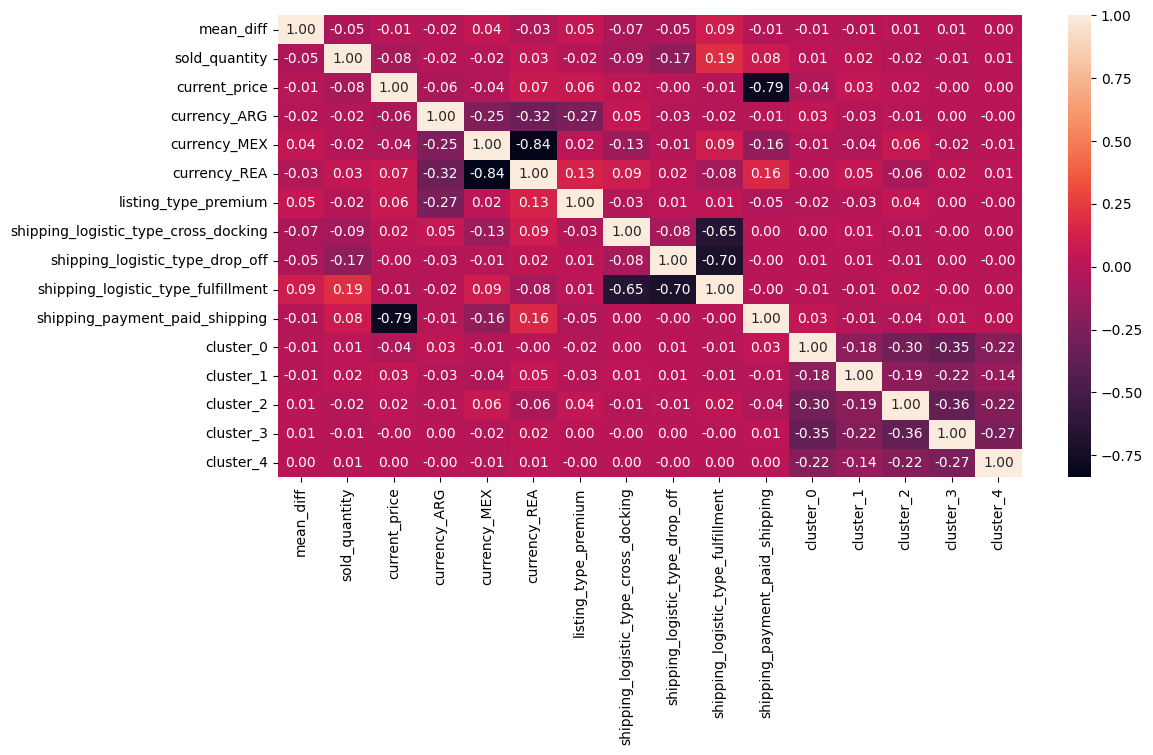

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(enconded_core_skus.drop(columns=["sku"]).corr(), annot=True, fmt=".2f")

First, note that site_id and currency represent the same information, so we'll rule out site_id.
On the other hand, our target variable (mean_diff) is not significantly correlated with any of the inputs. This already tells us that our predictions are not goint to be the best and the algothym will assign very similar probability distributions no matter the product.

In [ ]:
enconded_core_skus = enconded_core_skus.drop(columns=["site_id_MLA", "site_id_MLB", "site_id_MLM"])

In [62]:
#we're interested in the probabilities of an item being out of stock before 30 days since published.
enconded_core_skus["mean_diff"] = enconded_core_skus["mean_diff"].apply(lambda x: x if x <= 29 else -1)
#enconded_core_skus = enconded_core_skus[enconded_core_skus["mean_diff"] != -1]

<Axes: xlabel='index'>

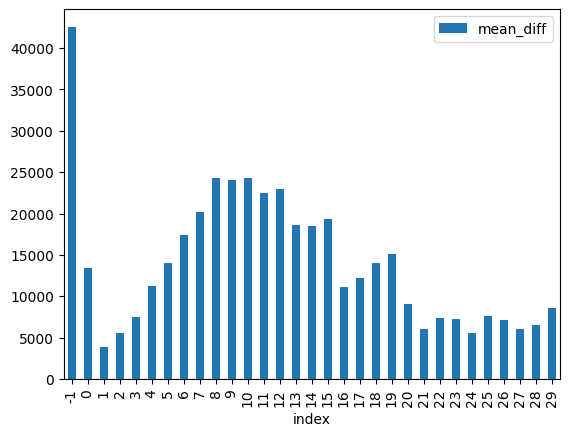

In [63]:
enconded_core_skus["mean_diff"].value_counts().reset_index().sort_values("index").plot.bar(x="index", y="mean_diff")

This is the shape we expect the probability distributions to follow no matter the product

In [64]:
enconded_core_skus

,sku,mean_diff,sold_quantity,current_price,currency_ARG,currency_MEX,currency_REA,listing_type_premium,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,shipping_payment_paid_shipping,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
2,2,0,0.010989,0.255175,0,1,0,1,0,1,0,1,0,0,0,1,0
3,3,14,0.087912,0.408232,0,1,0,1,0,0,1,0,0,0,0,1,0
5,5,25,0.164835,0.586047,0,1,0,1,0,0,1,0,0,0,1,0,0
6,6,22,0.318681,0.502843,0,1,0,0,0,0,1,0,0,0,1,0,0
9,9,-1,0.197802,0.228535,0,1,0,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535700,660907,13,0.111111,0.115773,0,0,1,1,0,0,1,1,0,0,0,0,1
535701,660908,12,0.925926,0.130087,0,0,1,1,0,0,1,1,0,0,0,1,0
535703,660911,7,0.234568,0.056592,0,0,1,0,0,0,1,1,0,0,1,0,0
535705,660913,16,0.123457,0.667103,0,0,1,1,0,0,1,0,0,0,0,1,0


In [65]:
from sklearn.model_selection import train_test_split

stratified_sample, _ = train_test_split(enconded_core_skus, test_size=0.95, stratify=enconded_core_skus['mean_diff'], random_state=42)

In [66]:
stratified_sample.shape

(21672, 17)

In [67]:
from scipy.stats import ks_2samp

population_data = enconded_core_skus['mean_diff']
sample_data = stratified_sample['mean_diff']


ks_statistic, p_value = ks_2samp(population_data, sample_data)

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

KS Statistic: 5.297291586925379e-05
P-value: 1.0


Aiming efficiency, we'll train using only a 5 percent stratified sample of the total population

In [68]:
from sklearn.model_selection import train_test_split

X, y = stratified_sample.drop(columns=["sku", "mean_diff"]), stratified_sample["mean_diff"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [31]:
# import pickle
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(
#     n_estimators=200,
#     random_state=SEED
# )
# rf.fit(X_train, y_train) #3:10

In [32]:
# y_pred = rf.predict(X_test) #4:30

In [33]:
# from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# accuracy_score(y_test, y_pred), recall_score(y_test, y_pred, average="weighted"), precision_score(y_test, y_pred, average="weighted"), f1_score(y_test, y_pred, average="weighted")
# (0.0771608854641304,
#  0.0771608854641304,
#  0.0767840488770633,
#  0.07695499028302633)

In [34]:
# pd.DataFrame({
#     "feature": X.columns,
#     "importance": rf.feature_importances_
# }).sort_values("importance", ascending=False).to_dict("records")

# [{'feature': 'current_price', 'importance': 0.801217352913041},
#  {'feature': 'sold_quantity', 'importance': 0.1836005788669527},
#  {'feature': 'listing_type_premium', 'importance': 0.0031601097320330808},
#  {'feature': 'shipping_payment_paid_shipping',
#   'importance': 0.0017772585323172084},
#  {'feature': 'cluster_3', 'importance': 0.0012983819026186377},
#  {'feature': 'cluster_2', 'importance': 0.001261195010281027},
#  {'feature': 'cluster_0', 'importance': 0.0012253716929992303},
#  {'feature': 'shipping_logistic_type_fulfillment',
#   'importance': 0.0011654902963192145},
#  {'feature': 'cluster_4', 'importance': 0.0011592737672161243},
#  {'feature': 'cluster_1', 'importance': 0.0010689177306804074},
#  {'feature': 'shipping_logistic_type_drop_off',
#   'importance': 0.0007992337060349648},
#  {'feature': 'currency_MEX', 'importance': 0.0006395776913709577},
#  {'feature': 'currency_REA', 'importance': 0.0005990527141678557},
#  {'feature': 'shipping_logistic_type_cross_docking',
#   'importance': 0.0005592449776688477},
#  {'feature': 'currency_ARG', 'importance': 0.000468960466298834}]

In [66]:
# import optuna
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score

# def objective(trial):
#     # Suggest a value for 'C'
#     C = trial.suggest_float('C', 0.01, 1)
#     penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    
#     # Create and train the model
#     model = LogisticRegression(random_state=42, n_jobs=-1, max_iter=1000, penalty=penalty, C=C, solver='saga')
#     score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=3, scoring="recall_weighted").mean()
    
#     return score

In [67]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

[I 2024-07-13 20:57:49,257] A new study created in memory with name: no-name-9e2b4740-a71c-4a84-af68-e88041273279
[I 2024-07-13 20:57:53,077] Trial 0 finished with value: 0.10786179846570919 and parameters: {'C': 0.643065841547086, 'penalty': 'l2'}. Best is trial 0 with value: 0.10786179846570919.
[I 2024-07-13 20:57:55,881] Trial 1 finished with value: 0.10693891676760686 and parameters: {'C': 0.24499556645796997, 'penalty': 'l1'}. Best is trial 0 with value: 0.10786179846570919.
[I 2024-07-13 20:57:58,465] Trial 2 finished with value: 0.10780411835957777 and parameters: {'C': 0.39487442025166647, 'penalty': 'l1'}. Best is trial 0 with value: 0.10786179846570919.
[I 2024-07-13 20:58:00,267] Trial 3 finished with value: 0.10826555920862894 and parameters: {'C': 0.5480883854321434, 'penalty': 'l1'}. Best is trial 3 with value: 0.10826555920862894.
[I 2024-07-13 20:58:01,965] Trial 4 finished with value: 0.10740035761665802 and parameters: {'C': 0.37014835566828086, 'penalty': 'l1'}. Bes

In [35]:
#study.best_params
best_params = {'C': 0.7828859442501774, 'penalty': 'l1'}

In [71]:
X_whole, y_whole = enconded_core_skus.drop(columns=["sku", "mean_diff"]), enconded_core_skus["mean_diff"]

X_whole_train, X_whole_test, y_whole_train, y_whole_test = train_test_split(X_whole, y_whole, test_size=0.2, random_state=SEED)

In [34]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(
    random_state=42,
    n_jobs=-1,
    max_iter=1000,
    penalty=best_params["penalty"],
    C=best_params["C"],
    solver='saga'
)

lr.fit(X_whole_train, y_whole_train)

LogisticRegression(C=0.7828859442501774, max_iter=1000, n_jobs=-1, penalty='l1',
                   random_state=42, solver='saga')

In [35]:
# with open("../storage/models/logistic_regression.pkl", "wb") as f:
#     pickle.dump(lr, f)

# with open("../storage/models/logistic_regression_rus.pkl", "wb") as f:
#     pickle.dump(lr_rus, f)

# with open("../storage/models/logistic_regression_smote.pkl", "wb") as f:
#     pickle.dump(lr_smote, f)

# with open("../storage/models/logistic_regression_best_params.pkl", "wb") as f:
#     pickle.dump(lr, f)

In [69]:
with open("../storage/models/logistic_regression_best_params.pkl", "rb") as f:
    lr = pickle.load(f)

In [72]:
lr_y_pred = lr.predict(X_whole_test)

In [73]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

(
    accuracy_score(y_whole_test, lr_y_pred),
    recall_score(y_whole_test, lr_y_pred, average="weighted"),
    precision_score(y_whole_test, lr_y_pred, average="weighted", zero_division=0),
    f1_score(y_whole_test, lr_y_pred, average="weighted")
)

(0.10918340273852507,
 0.10918340273852507,
 0.03929142384714892,
 0.03878284763033074)

In [40]:
#df with feature weights
pd.DataFrame({
    "feature": X_whole.columns,
    "weight": lr.coef_[0]
}).sort_values("weight", ascending=False)

,feature,weight
7,shipping_logistic_type_drop_off,3.221536e-01
5,listing_type_premium,2.279864e-01
3,currency_MEX,1.678992e-01
14,cluster_4,5.459331e-02
12,cluster_2,2.972419e-02
2,currency_ARG,0.000000e+00
6,shipping_logistic_type_cross_docking,0.000000e+00
13,cluster_3,-2.005350e-07
8,shipping_logistic_type_fulfillment,-1.354320e-02
10,cluster_0,-2.526560e-02


In [80]:
X_whole_test.iloc[:1]

,sold_quantity,current_price,currency_ARG,currency_MEX,currency_REA,listing_type_premium,shipping_logistic_type_cross_docking,shipping_logistic_type_drop_off,shipping_logistic_type_fulfillment,shipping_payment_paid_shipping,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4
401767,0.518519,0.305076,0,0,1,1,0,0,1,1,1,0,0,0,0


In [79]:
lr.predict_proba(X_whole_test.iloc[:1])

array([[0.0715808 , 0.00203519, 0.00526583, 0.00863221, 0.01155097,
        0.02239095, 0.03134088, 0.04551255, 0.05731325, 0.0676408 ,
        0.06723004, 0.06526127, 0.0620172 , 0.06166425, 0.05068641,
        0.04577488, 0.04892596, 0.02677872, 0.02881174, 0.03163963,
        0.03779296, 0.021642  , 0.01230675, 0.01822305, 0.01503188,
        0.01017866, 0.01505527, 0.01546937, 0.01309551, 0.01238489,
        0.01676614]])

In [74]:
tmp = pd.DataFrame(lr.predict_proba(X_whole_test), columns=lr.classes_)
tmp

,-1,0,1,2,3,4,5,6,7,8,...,20,21,22,23,24,25,26,27,28,29
0,0.071581,0.002035,0.005266,0.008632,0.011551,0.022391,0.031341,0.045513,0.057313,0.067641,...,0.021642,0.012307,0.018223,0.015032,0.010179,0.015055,0.015469,0.013096,0.012385,0.016766
1,0.101153,0.006476,0.011315,0.014533,0.020158,0.033032,0.034469,0.039096,0.044461,0.057716,...,0.020300,0.015370,0.014626,0.015189,0.015009,0.018811,0.017052,0.013966,0.015084,0.020297
2,0.076945,0.001078,0.007350,0.010867,0.015006,0.027128,0.039196,0.050740,0.059053,0.068244,...,0.019003,0.013765,0.013276,0.013453,0.012502,0.016745,0.014486,0.011636,0.013909,0.016978
3,0.104417,0.031122,0.008202,0.011496,0.013342,0.017590,0.019694,0.027164,0.035606,0.045455,...,0.025247,0.018591,0.022909,0.020659,0.012460,0.021380,0.019480,0.017194,0.016041,0.024260
4,0.080430,0.010958,0.008180,0.010688,0.014063,0.024183,0.029129,0.034845,0.042014,0.056610,...,0.023097,0.016282,0.016917,0.016719,0.012332,0.018004,0.018091,0.013868,0.018041,0.021342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86684,0.063337,0.002575,0.006029,0.008893,0.012090,0.024064,0.042255,0.052169,0.061259,0.073261,...,0.018766,0.012593,0.014279,0.015123,0.011050,0.014536,0.013211,0.011229,0.015466,0.016865
86685,0.110303,0.032657,0.008576,0.012095,0.014104,0.021357,0.024808,0.030840,0.037641,0.048164,...,0.022618,0.015691,0.020939,0.022151,0.014560,0.020464,0.019589,0.016975,0.017170,0.022132
86686,0.108620,0.010980,0.012353,0.015686,0.021122,0.032148,0.031771,0.035440,0.040479,0.053444,...,0.020904,0.016152,0.015265,0.016027,0.015712,0.019925,0.018132,0.014680,0.015757,0.021370
86687,0.051770,0.000096,0.004997,0.007042,0.012151,0.035598,0.056005,0.072072,0.078932,0.090176,...,0.014326,0.009190,0.009224,0.008935,0.009447,0.010763,0.009684,0.008399,0.009770,0.011930


In [42]:
tmp_graph = tmp.copy().drop(columns=[-1])

In [43]:
tmp_graph.idxmax(axis=1).mean(), y_whole_test[y_whole_test != -1].mean()

(8.60755113105469, 12.867379473717907)

Note that our predictions tell that most of the products have the highest probability of getting out-of-stock around the days 8-9. While in reality, most products get out of stock around the days 12-13.

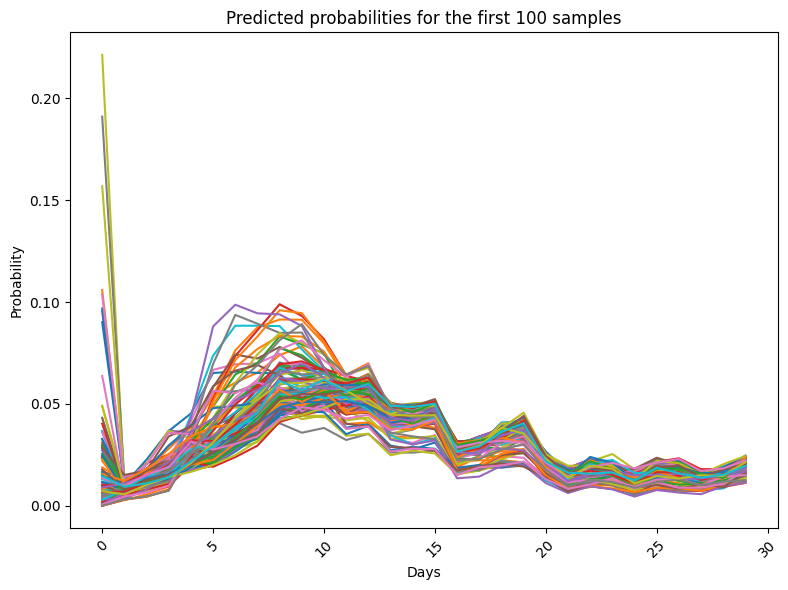

In [45]:
plt.figure(figsize=(8, 6))
for i in range(100):
    plt.plot(tmp_graph.columns, tmp_graph.iloc[i], label=f"sample_{i}")

plt.title("Predicted probabilities for the first 100 samples")
plt.xlabel("Days")
plt.ylabel("Probability")
plt.xticks(ticks=range(len(tmp_graph.columns)), labels=tmp_graph.columns, rotation=45)
plt.tight_layout()